In [176]:
import pandas as pd
from keras.layers import Input, LSTM, Dense, Concatenate
from keras.models import Model
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler

###plot
import numpy as np
import matplotlib.pyplot as plt

In [177]:
Train = pd.read_csv('WAL_MODEL_Train.csv')
Test = pd.read_csv('WAL_MODEL_Test.csv')
Valid = pd.read_csv('WAL_MODEL_Valid.csv')
COST_data = pd.read_csv('COST.csv')
KO_data = pd.read_csv('KO.csv')
PEP_data = pd.read_csv('PEP.csv')
PG_data = pd.read_csv('PG.csv')
NSRGY_data = pd.read_csv('NSRGY.csv')

In [178]:
df = pd.concat([Train,Test,Valid],ignore_index=True)
df['Date'] = pd.to_datetime(df['Date'], format='%Y/%m/%d')


In [179]:
for all_date in [COST_data, KO_data, PEP_data, PG_data, NSRGY_data]:
    all_date['Date'] = pd.to_datetime(all_date['Date'], format='%d/%m/%Y %H:%M:%S').dt.date


In [180]:
print(['COST', 'KO', 'PEP', 'PG', 'NSRGY']+df.columns[1:].to_list())

['COST', 'KO', 'PEP', 'PG', 'NSRGY', 'Date', 'WAL_Close', '6 Mo', '1 Yr', '2 Yr', '3 Yr', '5 Yr', '7 Yr', '10 Yr', '20 Yr', 'PCE', 'GDP', 'DXY_Close', 'CRE', 'CPI', 'UNRATE']


In [181]:
prices = pd.concat([COST_data['Close'], KO_data['Close'], PEP_data['Close'], PG_data['Close'], NSRGY_data['Close']],axis=1, ignore_index=True)
df = pd.concat([prices, df], axis=1, names=['COST', 'KO', 'PEP', 'PG', 'NSRGY']+df.columns[1:].to_list())

In [182]:
df = df.rename(columns={0:'COST', 1: "KO", 2: "PEP", 3:"PG", 4:'NSRGY'})

In [183]:
df = df.drop(labels=['Unnamed: 0'], axis=1)

In [184]:
### number of nan
df.isnull().sum()

COST           1
KO             1
PEP            0
PG             0
NSRGY         60
Date           0
WAL_Close      0
6 Mo          44
1 Yr          44
2 Yr          44
3 Yr          44
5 Yr          44
7 Yr          44
10 Yr         44
20 Yr         44
PCE            0
GDP           63
DXY_Close    114
CRE            2
CPI            0
UNRATE         0
dtype: int64

In [185]:
### use pervious values
df = df.fillna(method='backfill')

In [186]:
df[df['Date'] < pd.to_datetime('2022-10-03')].isnull().sum()

COST         0
KO           0
PEP          0
PG           0
NSRGY        0
Date         0
WAL_Close    0
6 Mo         0
1 Yr         0
2 Yr         0
3 Yr         0
5 Yr         0
7 Yr         0
10 Yr        0
20 Yr        0
PCE          0
GDP          0
DXY_Close    0
CRE          0
CPI          0
UNRATE       0
dtype: int64

In [187]:
df[df['Date'] < pd.to_datetime('2022-10-03')].to_csv('dataset.csv')

In [188]:
df_v1 = df[df['Date'] < pd.to_datetime('2022-10-03')]

In [189]:
df_v1['CPI'] = df_v1['CPI'].str[:3].astype(float)

C:\Users\Todd\AppData\Local\Temp\ipykernel_24860\4047843882.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_v1['CPI'] = df_v1['CPI'].str[:3].astype(float)


In [190]:
list_df_v1 = df_v1.columns

In [191]:
WINDOW_SIZE = 3
for col in list_df_v1:
  for i in range(WINDOW_SIZE): # Shift values for each step in WINDOW_SIZE
      df_v1[f"{col} +{i+1}"] = df_v1[f"{col}"].shift(periods=i+1)
df_v1.head()
     

C:\Users\Todd\AppData\Local\Temp\ipykernel_24860\3240552127.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_v1[f"{col} +{i+1}"] = df_v1[f"{col}"].shift(periods=i+1)
C:\Users\Todd\AppData\Local\Temp\ipykernel_24860\3240552127.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_v1[f"{col} +{i+1}"] = df_v1[f"{col}"].shift(periods=i+1)
C:\Users\Todd\AppData\Local\Temp\ipykernel_24860\3240552127.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using 

,COST,KO,PEP,PG,NSRGY,Date,WAL_Close,6 Mo,1 Yr,2 Yr,...,DXY_Close +3,CRE +1,CRE +2,CRE +3,CPI +1,CPI +2,CPI +3,UNRATE +1,UNRATE +2,UNRATE +3
0,44.50,28.13,36.88,52.93,18.35,2000-01-03,66.81,5.81,6.09,6.38,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,42.00,27.88,35.94,51.91,18.30,2000-01-04,64.38,5.75,6.00,6.30,...,NaN,1.16,NaN,NaN,0.3,NaN,NaN,4.0,NaN,NaN
2,42.78,28.47,35.06,50.83,18.00,2000-01-05,63.00,5.74,6.05,6.38,...,NaN,1.16,1.16,NaN,0.3,0.3,NaN,3.8,4.0,NaN
3,43.64,28.50,36.63,53.21,18.05,2000-01-06,63.69,5.69,6.03,6.35,...,104.889999,1.18,1.16,1.16,0.3,0.3,0.3,4.0,3.8,4.0
4,46.50,30.31,38.50,57.53,18.75,2000-01-07,68.50,5.66,6.00,6.31,...,105.440002,1.18,1.18,1.16,0.3,0.3,0.3,4.0,4.0,3.8


In [192]:
scaler_COST = MinMaxScaler(feature_range = (0,1))
COST = scaler_COST.fit_transform(df_v1['COST'].to_numpy().reshape(-1, 1))
scaler = MinMaxScaler(feature_range = (0,1))
KO = scaler.fit_transform(df_v1['KO'].to_numpy().reshape(-1, 1))

scaler = MinMaxScaler(feature_range = (0,1))
Yr10 = scaler.fit_transform(df_v1['10 Yr'].to_numpy().reshape(-1, 1))
scaler = MinMaxScaler(feature_range = (0,1))
DXY = scaler.fit_transform(df_v1['DXY_Close'].to_numpy().reshape(-1, 1))

scaler = MinMaxScaler(feature_range = (0,1))
CPI = scaler.fit_transform(df_v1['CPI'].to_numpy().reshape(-1, 1))
scaler = MinMaxScaler(feature_range = (0,1))
WAL = scaler.fit_transform(df_v1['WAL_Close'].to_numpy().reshape(-1, 1))


In [193]:
length_data = len(df_v1)     # rows that data has
split_ratio = 1           # %70 train + %30 validation
length_train = round(length_data * split_ratio)  

X_train_COST = []
y_train_COST = []

X_train_KO = []
y_train_KO = []

X_train_Yr10 = []
y_train_Yr10 = []

X_train_DXY = []
y_train_DXY = []

X_train_CPI = []
y_train_CPI = []

X_train_WAL = []
y_train_WAL = []


time_step = 14

for i in range(time_step, length_train):
    X_train_COST.append(COST[i-time_step:i])
    y_train_COST.append(COST[i])
    
    X_train_KO.append(KO[i-time_step:i])
    y_train_KO.append(KO[i])

    X_train_Yr10.append(Yr10[i-time_step:i])
    y_train_Yr10.append(Yr10[i])
    
    X_train_DXY.append(DXY[i-time_step:i])
    y_train_DXY.append(DXY[i])
    
    X_train_CPI.append(CPI[i-time_step:i])
    y_train_CPI.append(CPI[i])

    X_train_WAL.append(WAL[i-time_step:i])
    y_train_WAL.append(WAL[i])



In [194]:
np.array(X_train_COST).shape

(5711, 14, 1)

In [195]:
# convert list to array
num = 4000
X1_train_COST, X1_train_KO, y1_train_COST, y1_train_KO = np.array(X_train_COST[:num]),np.array(X_train_KO[:num]), np.array(y_train_COST[:num]), np.array(y_train_KO[:num])
X1_train_Yr10, X1_train_DXY, y1_train_Yr10, y1_train_DXY = np.array(X_train_Yr10[:num]),np.array(X_train_DXY[:num]), np.array(y_train_Yr10[:num]), np.array(y_train_DXY[:num])
X1_train_CPI, X1_train_WAL, y1_train_CPI, y1_train_WAL = np.array(X_train_CPI[:num]),np.array(X_train_WAL[:num]), np.array(y_train_CPI[:num]), np.array(y_train_WAL[:num])


X_test_COST, y_test_COST, X_test_KO, y_test_KO = np.array(X_train_COST[num:]), np.array(y_train_COST[num:]), np.array(X_train_KO[num:]), np.array(y_train_KO[num:])
X_test_Yr10, y_test_Yr10, X_test_DXY, y_test_DXY = np.array(X_train_Yr10[num:]), np.array(y_train_Yr10[num:]), np.array(X_train_DXY[num:]), np.array(y_train_DXY[num:])
X_test_CPI, y_test_CPI, X_test_WAL, y_test_WAL = np.array(X_train_CPI[num:]), np.array(y_train_CPI[num:]), np.array(X_train_WAL[num:]), np.array(y_train_WAL[num:])


In [196]:
#X_train_COST[..., np.newaxis].shape

<Figure size 640x480 with 0 Axes>

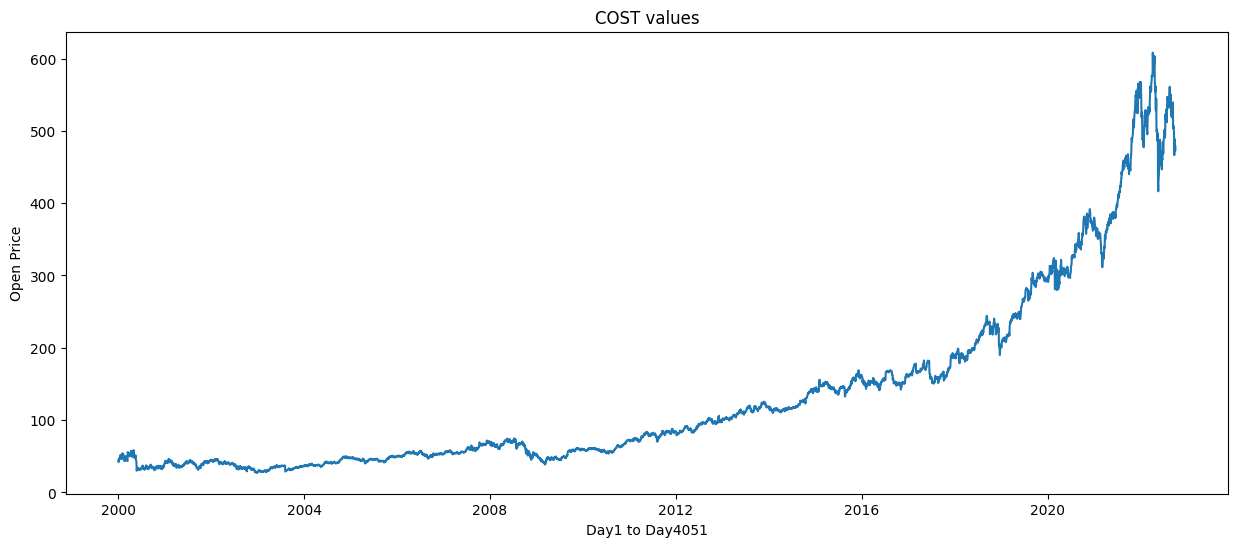

In [197]:
### PLOT graph
for tar in ['COST', 'KO', 'PEP', 'PG', 'NSRGY', 'WAL_Close', '6 Mo', '1 Yr', '2 Yr', '3 Yr', '5 Yr', '7 Yr', '10 Yr', '20 Yr', 'PCE', 'GDP',
       'DXY_Close', 'CRE', 'CPI', 'UNRATE']:
    plt.figure()
    plt.subplots(figsize = (15,6))
    plt.plot(df_v1.Date.values, df_v1[tar].values)
    plt.xlabel("Day1 to Day4051")
    plt.ylabel("Open Price")
    plt.title(tar+' values')
    plt.show()
    
    break

In [198]:
def lstm_sector(timesteps, units_l1, units_l2, X_train, y_train, X_val_dataset, y_val_data):

    # Define the inputs for each LSTM
    input1 = Input(shape=(timesteps, X_train[0].shape[-1]))
    lstm1 = LSTM(units_l1, return_sequences=True)(input1)
    lstm2 = LSTM(units_l2)(lstm1)

    input2 = Input(shape=(timesteps, X_train[1].shape[-1]))
    lstm3 = LSTM(units_l1, return_sequences=True)(input2)
    lstm4 = LSTM(units_l2)(lstm3)
    

    concat = Concatenate()([lstm2, lstm4])
    dense1 = Dense(16, activation='relu')(concat)
    output = Dense(1, activation='relu')(dense1)


    model = Model(inputs=[input1, input2], outputs=output)
    model.compile(loss='mean_squared_error', optimizer='adam', metrics = [tf.keras.metrics.MeanSquaredError(), tf.keras.metrics.MeanAbsoluteError()])

    # Train the model
    trained_model = model.fit(x=X_train, y=y_train, validation_data = (X_val_dataset, y_val_data), batch_size=16, epochs=10)

    return trained_model

def lstm_sector_c(timesteps, units_l1, units_l2, X_train, y_train, X_val_dataset, y_val_data):

    # Define the inputs for each LSTM
    input1 = Input(shape=(timesteps, X_train[0].shape[-1]))
    lstm1 = LSTM(units_l1, return_sequences=True)(input1)
    lstm2 = LSTM(units_l2)(lstm1)

    dense1 = Dense(25)(lstm2)
    output = Dense(1)(dense1)


    model = Model(inputs=[input1], outputs=output)
    model.compile(loss='mean_squared_error', optimizer='adam', metrics = [tf.keras.metrics.MeanSquaredError(), tf.keras.metrics.MeanAbsoluteError()])

    # Train the model
    model.fit(x=X_train, y=y_train, validation_data = (X_val_dataset, y_val_data), batch_size=32, epochs=5)

    return model



In [199]:
#core_model = lstm_sector_c(timesteps = time_step, units_l1=100, units_l2=100,X_train=X1_train_COST, y_train=y1_train_COST.flatten(), X_val_dataset=X_test_COST, y_val_data = y_test_COST.flatten())

In [200]:
#core_model.summary()

#predictions = core_model.predict(X_test_COST)
#predictions_result = scaler_COST.inverse_transform(predictions)
#y_test_COST_result = scaler_COST.inverse_transform(y_test_COST)
#X1_train_COST_result = scaler_COST.inverse_transform(X1_train_COST[:,0])
#X_Test_COST_result = scaler_COST.inverse_transform(X_test_COST[:,13])
#X1_train_COST
#rmse = (predictions_result - y_test_COST_result)/y_test_COST_result




In [201]:

#plt.figure()
#plt.subplots(figsize = (15,6))
#plt.plot(df_v1.Date.values[:num+time_step], df_v1['COST'].values[:num+time_step], 'black',label='Train_actual')
#plt.plot(df_v1.Date.values[num+time_step:],y_test_COST_result, 'ro', markersize=1, label='Test_actual')
#plt.plot(df_v1.Date.values[num+time_step:],predictions_result, label='Prediction')
#plt.legend()
#plt.xlabel("Time")
#plt.ylabel("Open Price")
#plt.title('COST prediction')
#plt.show()
#plt.clf()

#plt.figure()
#plt.subplots(figsize = (15,6))
#plt.plot(df_v1.Date.values[num+time_step:], rmse, label='Hyper')
#plt.plot(df_v1.Date.values[num+time_step:], (y_test_COST_result/X_Test_COST_result)-1, label='Actual movement')
#plt.xlabel("Time")
#plt.ylabel("Value")
#plt.title("Different between actual and prediction")
#plt.legend()
#plt.show()
#plt.clf()

In [202]:
#core_model = lstm_sector(timesteps = time_step, units_l1=32, units_l2=16,X_train=[X1_train_COST, 
#X1_train_KO], y_train=y1_train_COST, X_val_dataset=[X_test_COST, 
#X_test_KO], y_val_data = y_test_COST)

In [206]:
def lstm_sector_v1(timesteps, units_l1, units_l2, X_train, y_train, X_val_dataset, y_val_data, optimizer, batch_size, epoch):
    
    # Define the inputs for each LSTM
    input1 = Input(shape=(timesteps, X_train[0].shape[-1]))
    lstm1 = LSTM(units_l1, return_sequences=True)(input1)
    lstm2 = LSTM(units_l2)(lstm1)

    input2 = Input(shape=(timesteps, X_train[1].shape[-1]))
    lstm3 = LSTM(units_l1, return_sequences=True)(input2)
    lstm4 = LSTM(units_l2)(lstm3)
    
    input3 = Input(shape=(timesteps, X_train[2].shape[-1]))
    lstm5 = LSTM(units_l1, return_sequences=True)(input3)
    lstm6 = LSTM(units_l2)(lstm5)

    input4 = Input(shape=(timesteps, X_train[3].shape[-1]))
    lstm7 = LSTM(units_l1, return_sequences=True)(input4)
    lstm8 = LSTM(units_l2)(lstm7)

    input5 = Input(shape=(timesteps, X_train[4].shape[-1]))
    lstm9 = LSTM(units_l1, return_sequences=True)(input5)
    lstm10 = LSTM(units_l2)(lstm9)

    input6 = Input(shape=(timesteps, X_train[5].shape[-1]))
    lstm11 = LSTM(units_l1, return_sequences=True)(input6)
    lstm12 = LSTM(units_l2)(lstm11)

    concat = Concatenate()([lstm2, lstm4, lstm6, lstm8, lstm10, lstm12])
    dense1 = Dense(128, activation='relu')(concat)
    dense2 = Dense(32, activation='relu')(dense1)
    output = Dense(1, activation='relu')(dense2)


    model = Model(inputs=[input1, input2, input3, input4, input5, input6], outputs=output)
    model.compile(loss='mean_squared_error', optimizer=optimizer, metrics = [tf.keras.metrics.MeanSquaredError(), tf.keras.metrics.MeanAbsoluteError()])

    # Train the model
    model = model.fit(x=X_train, y=y_train, validation_data = (X_val_dataset, y_val_data), batch_size=batch_size, epochs=epoch)

    return model

In [207]:
learning_rate = [0.001]
batch_size = [32]
epochs = [10]
model_pool = []


for lr in learning_rate:
    optimizers = [tf.keras.optimizers.legacy.Adam(lr)]
    for bs in batch_size:
        for epoch in epochs:
            for op in optimizers:
                model_pool.append(lstm_sector_v1(timesteps = time_step, units_l1=64, units_l2=64
                , X_train = [X1_train_COST, X1_train_KO, X1_train_Yr10, X1_train_DXY, X1_train_CPI, X1_train_WAL]
                , y_train = y1_train_COST.flatten()
                , X_val_dataset=[X_test_COST, X_test_KO, X_test_Yr10, X_test_DXY, X_test_CPI, X_test_WAL]
                , y_val_data = y_test_COST.flatten(), optimizer = op, batch_size = bs, epoch = epoch))
                 

Epoch 1/10
125/125 [==============================] - 39s 262ms/step - loss: 3.3396e-04 - mean_squared_error: 3.3396e-04 - mean_absolute_error: 0.0102 - val_loss: 0.0032 - val_mean_squared_error: 0.0032 - val_mean_absolute_error: 0.0344
Epoch 2/10
125/125 [==============================] - 30s 240ms/step - loss: 2.0864e-05 - mean_squared_error: 2.0864e-05 - mean_absolute_error: 0.0035 - val_loss: 0.0033 - val_mean_squared_error: 0.0033 - val_mean_absolute_error: 0.0356
Epoch 3/10
125/125 [==============================] - 30s 239ms/step - loss: 2.4028e-05 - mean_squared_error: 2.4028e-05 - mean_absolute_error: 0.0037 - val_loss: 0.0043 - val_mean_squared_error: 0.0043 - val_mean_absolute_error: 0.0424
Epoch 4/10
125/125 [==============================] - 30s 238ms/step - loss: 2.6408e-05 - mean_squared_error: 2.6408e-05 - mean_absolute_error: 0.0039 - val_loss: 0.0066 - val_mean_squared_error: 0.0066 - val_mean_absolute_error: 0.0559
Epoch 5/10
125/125 [==============================] 

In [208]:
len(model_pool)

1

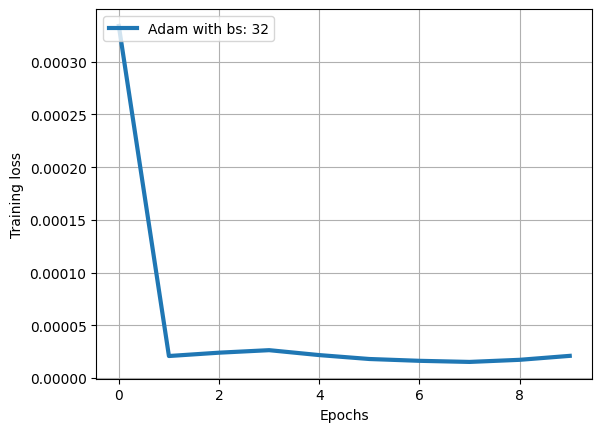

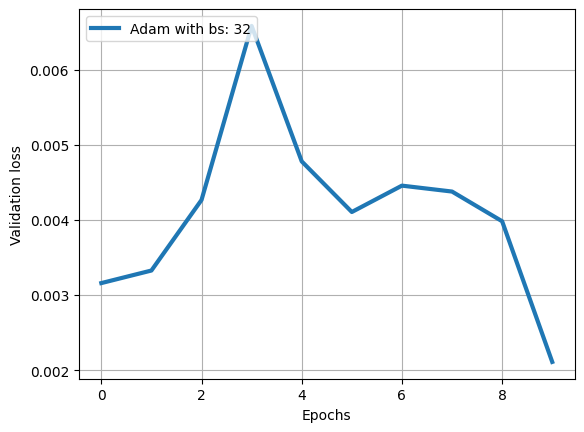

In [211]:
for loss in ("loss", "val_loss"):
  plt.plot(model_pool[0].history[loss], label="Adam with bs: 32", linewidth =3)

  plt.grid()
  plt.xlabel("Epochs")
  plt.ylabel({"loss": "Training loss", "val_loss": "Validation loss"}[loss])
  plt.legend(loc="upper left")
  plt.show()

In [204]:
learning_rate = [0.001]
batch_size = [32]
epochs = [10]
model_pool = []


for lr in learning_rate:
    optimizers = [tf.keras.optimizers.legacy.Nadam(lr), tf.keras.optimizers.legacy.Adam(lr), tf.keras.optimizers.legacy.SGD(lr), tf.keras.optimizers.legacy.RMSprop(lr)]
    for bs in batch_size:
        for epoch in epochs:
            for op in optimizers:
                model_pool.append(lstm_sector_v1(timesteps = time_step, units_l1=64, units_l2=64
                , X_train = [X1_train_COST, X1_train_KO, X1_train_Yr10, X1_train_DXY, X1_train_CPI, X1_train_WAL]
                , y_train = y1_train_COST.flatten()
                , X_val_dataset=[X_test_COST, X_test_KO, X_test_Yr10, X_test_DXY, X_test_CPI, X_test_WAL]
                , y_val_data = y_test_COST.flatten(), optimizer = op, batch_size = bs, epoch = epoch))
                 



Epoch 1/10
125/125 [==============================] - 34s 178ms/step - loss: 0.0080 - mean_squared_error: 0.0080 - mean_absolute_error: 0.0687 - val_loss: 0.2441 - val_mean_squared_error: 0.2441 - val_mean_absolute_error: 0.4445
Epoch 2/10
125/125 [==============================] - 20s 158ms/step - loss: 0.0080 - mean_squared_error: 0.0080 - mean_absolute_error: 0.0687 - val_loss: 0.2441 - val_mean_squared_error: 0.2441 - val_mean_absolute_error: 0.4445
Epoch 3/10
125/125 [==============================] - 20s 162ms/step - loss: 0.0080 - mean_squared_error: 0.0080 - mean_absolute_error: 0.0687 - val_loss: 0.2441 - val_mean_squared_error: 0.2441 - val_mean_absolute_error: 0.4445
Epoch 4/10
125/125 [==============================] - 21s 170ms/step - loss: 0.0080 - mean_squared_error: 0.0080 - mean_absolute_error: 0.0687 - val_loss: 0.2441 - val_mean_squared_error: 0.2441 - val_mean_absolute_error: 0.4445
Epoch 5/10
125/125 [==============================] - 21s 167ms/step - loss: 0.0080 

In [205]:
label_pool = []
for lr in learning_rate:
    for opt in ['Nadam','Adam', 'SGD', 'RMSprop']:
        for bs in batch_size:
            label_pool.append(opt+' with bs : ' +str(bs) + ' with lr : '+ str(lr))

result_pool=[]     
for modelraw, label in zip(model_pool, label_pool):

    predictions = modelraw.predict(X_test_COST)
    predictions_result = scaler_COST.inverse_transform(predictions)
    print(predictions.mean())
    y_test_COST_result = scaler_COST.inverse_transform(y_test_COST)
    rmse = (predictions_result - y_test_COST_result)/y_test_COST_result
    print([rmse.mean(),label])
    result_pool.append([abs(rmse.mean()),label])

ValueError: in user code:

    File "c:\Users\Todd\anaconda3\envs\deeplearning\lib\site-packages\keras\engine\training.py", line 2137, in predict_function  *
        return step_function(self, iterator)
    File "c:\Users\Todd\anaconda3\envs\deeplearning\lib\site-packages\keras\engine\training.py", line 2123, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "c:\Users\Todd\anaconda3\envs\deeplearning\lib\site-packages\keras\engine\training.py", line 2111, in run_step  **
        outputs = model.predict_step(data)
    File "c:\Users\Todd\anaconda3\envs\deeplearning\lib\site-packages\keras\engine\training.py", line 2079, in predict_step
        return self(x, training=False)
    File "c:\Users\Todd\anaconda3\envs\deeplearning\lib\site-packages\keras\utils\traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "c:\Users\Todd\anaconda3\envs\deeplearning\lib\site-packages\keras\engine\input_spec.py", line 216, in assert_input_compatibility
        raise ValueError(

    ValueError: Layer "model_14" expects 6 input(s), but it received 1 input tensors. Inputs received: [<tf.Tensor 'IteratorGetNext:0' shape=(None, 14, 1) dtype=float32>]


In [ ]:
label_pool = []
for opt in ['Nadam','Adam', 'SGD', 'RMSprop']:
    for bs in batch_size:
        label_pool.append(opt+' with batch_size : ' + str(bs))
        
for modelraw, label in zip(model_pool, label_pool):

    predictions = modelraw.predict([X_test_COST, X_test_KO, X_test_Yr10, X_test_DXY, X_test_CPI, X_test_WAL])
    predictions_result = scaler_COST.inverse_transform(predictions)
    print(predictions_result.mean())
    y_test_COST_result = scaler_COST.inverse_transform(y_test_COST)
    rmse = (predictions_result - y_test_COST_result)/y_test_COST_result
    print(rmse.mean(),label)

In [ ]:
label_pool = []
for opt in ['Nadam','Adam', 'SGD', 'RMSprop']:
    for bs in batch_size:
        label_pool.append(opt+' with batch_size : ' + str(bs))

plt.figure()
plt.subplots(figsize = (15,6))

for modelraw, label in zip(model_pool, label_pool):

    predictions = modelraw.predict([X_test_COST, X_test_KO, X_test_Yr10, X_test_DXY, X_test_CPI, X_test_WAL])
    predictions_result = scaler_COST.inverse_transform(predictions)
    print(predictions.mean())
    y_test_COST_result = scaler_COST.inverse_transform(y_test_COST)
    rmse = (predictions_result - y_test_COST_result)/y_test_COST_result
    plt.plot(df_v1.Date.values[num+time_step:],predictions_result, label='Prediction '+ label)
    print(label)
plt.plot(df_v1.Date.values[:num+time_step], df_v1['COST'].values[:num+time_step], 'black',label='Train_actual')
plt.plot(df_v1.Date.values[num+time_step:],y_test_COST_result, 'ro', markersize=1, label='Test_actual')
plt.legend()
plt.xlabel("Time")
plt.ylabel("Open Price")
plt.title('COST prediction')
plt.show()
plt.clf()

### plt different
plt.figure()
plt.subplots(figsize = (15,6))


for modelraw, label in zip(model_pool, label_pool):
    modelraw.summary()

    predictions = modelraw.predict([X_test_COST, X_test_KO, X_test_Yr10, X_test_DXY, X_test_CPI, X_test_WAL])
    predictions_result = scaler_COST.inverse_transform(predictions)
    y_test_COST_result = scaler_COST.inverse_transform(y_test_COST)
    rmse = (predictions_result - y_test_COST_result)/y_test_COST_result

    X_Test_COST_result = scaler_COST.inverse_transform(X_test_COST[:,13])
    actual_move = (y_test_COST_result - X_Test_COST_result)/ X_Test_COST_result * 100

    plt.plot(df_v1.Date.values[num+time_step:], rmse*100, label ='Hyper : '+label)

plt.plot(df_v1.Date.values[num+time_step:], actual_move, label='Actual movement')
plt.xlabel("Time")
plt.ylabel("Value")
plt.title("Different between actual and prediction")
plt.legend()
plt.show()
plt.clf()